# Smart sprinkler with non-linear regression



Imagine you have a large, square field and you've installed a new "smart" sprinkler system. You want to model its watering pattern. The sprinkler is located at the center of the field and waters the most in a circular area around it, with the water coverage fading out as you move further away.

Your goal is to create a model that predicts the Water Level on the ground based on its coordinates in the field.

Input Features (Independent Variables):
- x_coordinate: The position along the field's x-axis.
- y_coordinate: The position along the field's y-axis.

Target Output (Dependent Variable):
- Water_Level: A score from roughly 0 to 100 representing how much water a spot received.

## Set up environment

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.draw_graph import draw_dot
from src.model.builder import build_model
from src.model.training import train_model
from src.model.evaluation import evaluate_model
from src.model.hp_tuning import start_hp_search

import random
random.seed(42)

import numpy as np
np.random.seed(42) 

import pandas as pd
from pandas import DataFrame

from matplotlib import pyplot as plt

## Hyperparams

In [2]:
TEST_SIZE = 0.1

EPOCHS = 1000

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_DELTA = 1e-3

## Load data

In [3]:
df = pd.read_csv("smart_sprinkler_data.csv", sep=",")
df = df.sample(frac=1, random_state=42)
df.head()

,x_coord,y_coord,Water_Level
696,-4.227389,2,65
667,-6.786373,-1,37
63,-2.864933,-1,79
533,1.108634,9,9
66,-7.181516,-6,17


### Separate input from target

In [4]:
targets = df["Water_Level"]
inputs = df.drop(["Water_Level"], axis=1)

In [5]:
inputs.min()

x_coord   -9.898768
y_coord   -9.000000
dtype: float64

In [6]:
inputs.max()

x_coord    9.994353
y_coord    9.000000
dtype: float64

### Feature Engineering

In [7]:
inputs["distance_from_center"] = np.sqrt((inputs["x_coord"])**2 + (inputs["y_coord"])**2)
inputs = inputs.drop(["x_coord", "y_coord"], axis=1)

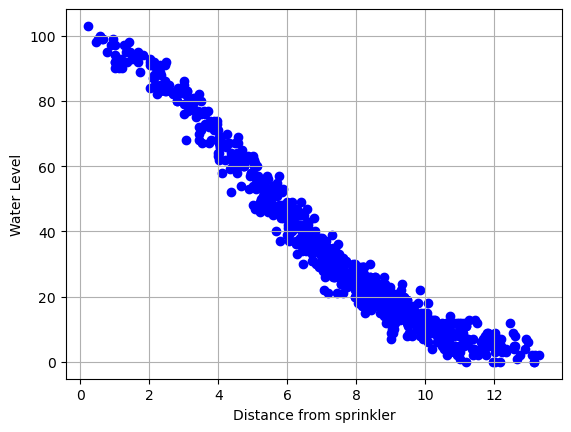

In [8]:
plt.scatter(inputs["distance_from_center"], targets, color='blue', marker='o', label='Data Points')

plt.xlabel("Distance from sprinkler")
plt.ylabel("Water Level")
plt.grid(True)
plt.show()

### Normalize input

In [9]:
def normalize_input(X: DataFrame):
    result = (X - X.min()) / (X.max() - X.min())
    return result

In [10]:
norm_inputs = normalize_input(inputs)

In [11]:
norm_inputs.min()

distance_from_center    0.0
dtype: float64

In [12]:
norm_inputs.max()

distance_from_center    1.0
dtype: float64

### Numpy

In [13]:
inputs = norm_inputs.to_numpy()
inputs[:5]

array([[0.33986963],
       [0.50685877],
       [0.21425222],
       [0.67578637],
       [0.697976  ]])

In [14]:
inputs.shape

(800, 1)

In [15]:
n_inputs = inputs.shape[1]

In [16]:
targets = targets.to_numpy()
targets[:5]

array([65, 37, 79,  9, 17])

### Train vs. Test set

In [17]:
test_size = int(len(inputs) * TEST_SIZE)
print(f"Train size: {len(inputs) - test_size}, Test size: {test_size}")

inputs_train = inputs[:-test_size]
targets_train = targets[:-test_size]

inputs_test = inputs[-test_size:]
targets_test = targets[-test_size:]

Train size: 720, Test size: 80


## Train Model

### Hyperparameter tuning

In [18]:
# Grid Search
hp_grid = {
    "learning_rate": [5e-3, 1e-3, 5e-4],
    "batch_size": [2, 4, 8],
    "hidden_layers": [1],
    "hidden_neurons": [16, 32]
}

def train_and_evaluate(hp_config):
    inputs, target, _, loss = build_model(n_inputs, hp_config["hidden_layers"], hp_config["hidden_neurons"])
    train_model(inputs_train, inputs_test, targets_train, targets_test, EPOCHS, hp_config["batch_size"], hp_config["learning_rate"], inputs, target, loss, EARLY_STOPPING_PATIENCE, EARLY_STOPPING_DELTA, log=False)
    average_loss = evaluate_model(inputs_test, targets_test, inputs, target, loss)
    return average_loss

best_hp_config = start_hp_search(hp_grid, train_and_evaluate)

Search iteration: 1
Testing config: {'learning_rate': 0.005, 'batch_size': 2, 'hidden_layers': 1, 'hidden_neurons': 16}
Loss: 50.851247493085275
Search iteration: 2
Testing config: {'learning_rate': 0.005, 'batch_size': 2, 'hidden_layers': 1, 'hidden_neurons': 32}
Loss: 14.584138445989518
Search iteration: 3
Testing config: {'learning_rate': 0.005, 'batch_size': 4, 'hidden_layers': 1, 'hidden_neurons': 16}
Loss: 14.652087007576057
Search iteration: 4
Testing config: {'learning_rate': 0.005, 'batch_size': 4, 'hidden_layers': 1, 'hidden_neurons': 32}
Loss: 14.094111793865679
Search iteration: 5
Testing config: {'learning_rate': 0.005, 'batch_size': 8, 'hidden_layers': 1, 'hidden_neurons': 16}
Loss: 14.317193588319688
Search iteration: 6
Testing config: {'learning_rate': 0.005, 'batch_size': 8, 'hidden_layers': 1, 'hidden_neurons': 32}
Loss: 14.52568152607077
Search iteration: 7
Testing config: {'learning_rate': 0.001, 'batch_size': 2, 'hidden_layers': 1, 'hidden_neurons': 16}
Loss: 12.76

In [19]:
batch_size = best_hp_config["batch_size"]
print(f"Best batch size: {batch_size}")

learning_rate = best_hp_config["learning_rate"]
print(f"Best learning rate: {learning_rate}")

hidden_layers = best_hp_config["hidden_layers"]
print(f"Best number of hidden layers: {hidden_layers}")

hidden_neurons = best_hp_config["hidden_neurons"]
print(f"Best number of neurons in hidden layer: {hidden_neurons}")

Best batch size: 4
Best learning rate: 0.001
Best number of hidden layers: 1
Best number of neurons in hidden layer: 32


### Training

In [20]:
inputs, target, output, loss = build_model(n_inputs, hidden_layers, hidden_neurons)

history = train_model(inputs_train, inputs_test, targets_train, targets_test, EPOCHS, batch_size, learning_rate, inputs, target, loss, EARLY_STOPPING_PATIENCE, EARLY_STOPPING_DELTA)

Epoch 0: loss=680.1217052632236, test_loss=inf
Epoch 1: loss=148.91345028818816, test_loss=276.29941236888135
Epoch 2: loss=35.298260333556584, test_loss=54.729541080659956
Epoch 3: loss=20.973431243112856, test_loss=26.021136481628766
Epoch 4: loss=16.980436200106805, test_loss=19.026042140647128
Epoch 5: loss=15.425272916366053, test_loss=17.21979633878315
Epoch 6: loss=16.432755532632054, test_loss=15.400855384384096
Epoch 7: loss=14.857826461535518, test_loss=15.726446764463532
Epoch 8: loss=14.815155897570488, test_loss=14.893640261237499
Epoch 9: loss=15.010731704780559, test_loss=16.84855294363772
Epoch 10: loss=14.452434273161392, test_loss=16.28783221019642
Epoch 11: loss=14.014688537610578, test_loss=13.259678648069023
Epoch 12: loss=14.693568050562217, test_loss=19.785464836271807
Epoch 13: loss=15.332136611356004, test_loss=16.024592960978346
Epoch 14: loss=13.986505749232874, test_loss=16.041497735222883
Epoch 15: loss=14.191671584312056, test_loss=14.519523109937143
Epoch

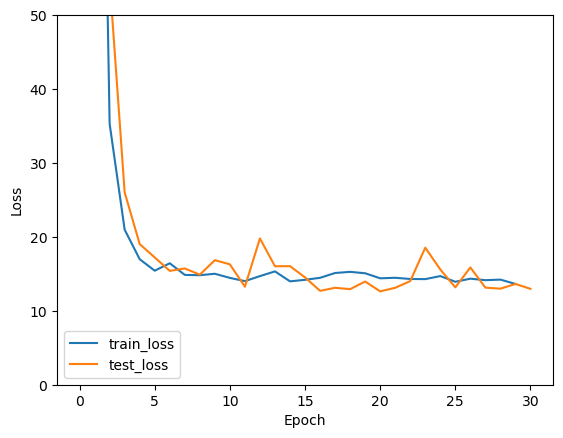

In [21]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 50)
plt.legend(loc="lower left")

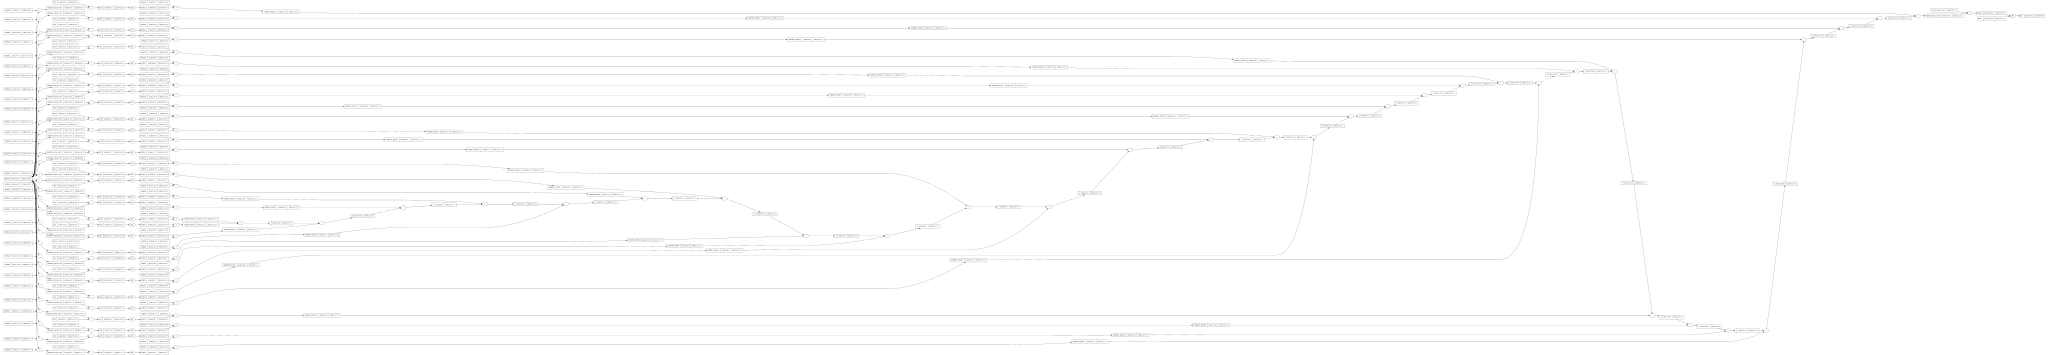

In [22]:
draw_dot(loss)

## Test solution

In [23]:
average_loss = evaluate_model(inputs_test, targets_test, inputs, target, loss)

In [24]:
rmse = np.sqrt(average_loss)
mean_target = np.mean(targets)
print("RMSE:", rmse)
print("Mean of targets:", mean_target)
print("Error as percentage of mean:", rmse / mean_target * 100)

RMSE: 3.5539301857858714
Mean of targets: 34.54375
Error as percentage of mean: 10.288200284525772
